# Lambda School Data Science - Logistic Regression

Logistic regression is the baseline for classification models, as well as a handy way to predict probabilities (since those too live in the unit interval). While relatively simple, it is also the foundation for more sophisticated classification techniques such as neural networks (many of which can effectively be thought of as networks of logistic models).

## Lecture - Where Linear goes Wrong
### Return of the Titanic 🚢

You've likely already explored the rich dataset that is the Titanic - let's use regression and try to predict survival with it. The data is [available from Kaggle](https://www.kaggle.com/c/titanic/data), so we'll also play a bit with [the Kaggle API](https://github.com/Kaggle/kaggle-api).

### Get data, option 1: Kaggle API

#### Sign up for Kaggle and get an API token
1. [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. 
2. [Follow these instructions](https://github.com/Kaggle/kaggle-api#api-credentials) to create a Kaggle “API Token” and download your `kaggle.json` file. If you are using Anaconda, put the file in the directory specified in the instructions.

_This will enable you to download data directly from Kaggle. If you run into problems, don’t worry — I’ll give you an easy alternative way to download today’s data, so you can still follow along with the lecture hands-on. And then we’ll help you through the Kaggle process after the lecture._

#### Put `kaggle.json` in the correct location

- ***If you're using Anaconda,*** put the file in the directory specified in the [instructions](https://github.com/Kaggle/kaggle-api#api-credentials).

- ***If you're using Google Colab,*** upload the file to your Google Drive, and run this cell:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%env KAGGLE_CONFIG_DIR=/content/drive/My Drive/

#### Install the Kaggle API package and use it to get the data

You also have to join the Titanic competition to have access to the data

In [ ]:
!pip install kaggle

In [ ]:
!kaggle competitions download -c titanic

### Get data, option 2: Download from the competition page
1. [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. 
2. [Go to the Titanic competition page](https://www.kaggle.com/c/titanic) to download the [data](https://www.kaggle.com/c/titanic/data).

### Get data, option 3: Use Seaborn

```
import seaborn as sns
train = sns.load_dataset('titanic')
```

But Seaborn's version of the Titanic dataset is not identical to Kaggle's version, as we'll see during this lesson!

### Read data

In [1]:
import pandas as pd
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
train.shape, test.shape

((891, 12), (418, 11))

Notice that `train.csv` has one more column than `test.csv` : The target, `Survived`.

Kaggle provides test labels, but not test targets. Instead, you submit your test predictions to Kaggle to get your test scores. Why? This is model validaton best practice, makes competitons fair, and helps us learn about over- and under-fitting.

In [2]:
train.sample(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
372,373,0,3,"Beavan, Mr. William Thomas",male,19.0,0,0,323951,8.0500,NaN,S
315,316,1,3,"Nilsson, Miss. Helmina Josefina",female,26.0,0,0,347470,7.8542,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.5500,NaN,S
192,193,1,3,"Andersen-Jensen, Miss. Carla Christine Nielsine",female,19.0,1,0,350046,7.8542,NaN,S
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S


In [3]:
test.sample(n=5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
349,1241,2,"Walcroft, Miss. Nellie",female,31.0,0,0,F.C.C. 13528,21.0000,NaN,S
23,915,1,"Williams, Mr. Richard Norris II",male,21.0,0,1,PC 17597,61.3792,NaN,C
105,997,3,"Holthen, Mr. Johan Martin",male,28.0,0,0,C 4001,22.5250,NaN,S
16,908,2,"Keane, Mr. Daniel",male,35.0,0,0,233734,12.3500,NaN,Q
115,1007,3,"Chronopoulos, Mr. Demetrios",male,18.0,1,0,2680,14.4542,NaN,C


Do some data exploration. 

About 62% of passengers did not survive.

In [4]:
target = 'Survived'
train[target].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

Describe the numeric columns

In [5]:
train.describe(include='number')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Describe the non-numeric columns

In [6]:
train.describe(exclude='number')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Rice, Master. George Hugh",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


### How would we try to do this with linear regression?

We choose a few numeric features, split the data into X and y, [impute missing values](https://scikit-learn.org/stable/modules/impute.html), and fit a Linear Regression model on the train set.

In [7]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression

features = ['Pclass', 'Age', 'Fare']
target  = 'Survived'
X_train = train[features]
y_train = train[target]
X_test  = test[features]

imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed  = imputer.transform(X_test)

lin_reg = LinearRegression()
lin_reg.fit(X_train_imputed, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Let's consider a test case. What does our Linear Regression predict for a 1st class, 5 year-old, with a fare of 500?

119% probability of survival.

In [8]:
import numpy as np
test_case = np.array([[1, 5, 500]]) # Rich 5-year old in first class
lin_reg.predict(test_case)

array([1.19207871])

Based on the Linear Regression's intercept and coefficients, it will predict probabilities greater than 100%, or less than 0%, given high enough / low enough values for the features.

In [9]:
print('Intercept', lin_reg.intercept_)
coefficients = pd.Series(lin_reg.coef_, X_train.columns)
print(coefficients.to_string())

Intercept 1.063899500003547
Pclass   -0.210390
Age      -0.007358
Fare      0.000751


### How would we do this with Logistic Regression?

The scikit-learn API is consistent, so the code is similar.

We instantiate our model (here with `LogisticRegression()` instead of `LinearRegression()`)

We use the same method to fit the model on the training data: `.fit(X_train_imputed, y_train)`

We use the same method to make a predict for our test case: `.predict(test_case)` — But this returns different results. Regressors return continuous values, but classifiers return discrete predictions of the class label. In this binary classification problem, our discrete class labels are `0` (did not survive) or `1` (did survive).

Classifiers also have a `.predict_proba` method, which returns predicted probabilities for each class. The probabilities sum to 1. 

We predict ~3% probability that our test case did not surive, and 97% probability that our test case did survive. This result is what we want and expect for our test case: to predict survival, with high probability, but less than 100%.

In [10]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Prediction for rich 5 year old:', log_reg.predict(test_case))
print('Predicted probabilities for rich 5 year old:', log_reg.predict_proba(test_case))

Prediction for rich 5 year old: [1]
Predicted probabilities for rich 5 year old: [[0.02778799 0.97221201]]


Logistic Regression calculates predicted probablities between the range of 0 and 1. By default, scikit-learn makes a discrete prediction by returning whichever class had the highest predicted probability for that observation.

In the case of binary classification, this is equivalent to using a threshold of 0.5. However, we could choose a different threshold, for different trade-offs between false positives versus false negatives.

In [11]:
threshold = 0.5
probabilities = log_reg.predict_proba(X_test_imputed)[:,1]
manual_predictions = (probabilities > threshold).astype(int)
direct_predictions = log_reg.predict(X_test_imputed)
all(manual_predictions == direct_predictions)

True

### How accurate is the Logistic Regression?

Scikit-learn estimators provide a convenient method, `.score`. It uses the X features to generate predictions. Then it compares the predictions to the y ground truth labels. Then it returns the score.

For regressors, `.score` returns R^2.

For classifiers, `.score` returns Accuracy.

Our Logistic Regression model has 70% training accuracy. (This is higher than the 62% accuracy we would get with a baseline that predicts every passenger does not survive.)

In [12]:
score = log_reg.score(X_train_imputed, y_train)
print('Train Accuracy Score', score)

Train Accuracy Score 0.7025813692480359


Accuracy is just the number of correct predictions divided by the total number of predictions.

For example, we can look at our first five predictions:

In [13]:
y_pred = log_reg.predict(X_train_imputed)

In [14]:
y_pred[:5]

array([0, 1, 0, 1, 0])

And compare to the ground truth labels for these first five observations:

In [15]:
y_train[:5].values

array([0, 1, 1, 1, 0])

We have four correct predictions, divided by five total predictions, for 80% accuracy.

In [16]:
correct_predictions = 4
total_predictions = 5
accuracy = correct_predictions / total_predictions
print(accuracy)

0.8


scikit-learn's `accuracy_score` function works the same way and returns the same result.

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train[:5], y_pred[:5])

0.8

We don't want to just score our model on the training data.

We cannot calculate a test accuracy score ourselves in this notebook, because Kaggle does not provide test labels.

We could split the train data into train and validation sets. However, we don't have many observations. (Fewer than 1,000.)

As another alternative, we can use cross-validation:

In [18]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(log_reg, X_train_imputed, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.63333333 0.62222222 0.68539326 0.71910112 0.69662921 0.69662921
 0.76404494 0.75280899 0.73033708 0.71590909]


We can see a range of scores: 

In [19]:
scores = pd.Series(scores)
scores.min(), scores.mean(), scores.max()

(0.6222222222222222, 0.7016408466689366, 0.7640449438202247)

To learn more about Cross-Validation, see these links:

- https://scikit-learn.org/stable/modules/cross_validation.html
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
- https://github.com/LambdaSchool/DS-Unit-2-Sprint-3-Classification-Validation/blob/master/module2-baselines-validation/model-validation-preread.md#what-is-cross-validation

### What's the equation for Logistic Regression?

https://en.wikipedia.org/wiki/Logistic_function

https://en.wikipedia.org/wiki/Logistic_regression#Probability_of_passing_an_exam_versus_hours_of_study

In [20]:
print('Intercept', log_reg.intercept_[0])
coefficients = pd.Series(log_reg.coef_[0], X_train.columns)
print(coefficients.to_string())

Intercept 2.557639851374306
Pclass   -0.934527
Age      -0.035697
Fare      0.004221


In [21]:
# The logistic sigmoid "squishing" function, 
# implemented to work with numpy arrays

def sigmoid(x):
    return 1 / (1 + np.e**(-x))

sigmoid(np.dot(log_reg.coef_, test_case.T) + log_reg.intercept_)

array([[0.97221201]])

Or we can write the code with the `@` operator instead of numpy's dot product function

In [22]:
sigmoid(log_reg.coef_ @ test_case.T + log_reg.intercept_)

array([[0.97221201]])

Either way, we get the same result as our scikit-learn Logistic Regression

In [23]:
log_reg.predict_proba(test_case)

array([[0.02778799, 0.97221201]])

## Feature Engineering

Get the [Category Encoder](http://contrib.scikit-learn.org/categorical-encoding/) library

If you're running on Google Colab:

```
!pip install category_encoders
```

If you're running locally with Anaconda:

```
!conda install -c conda-forge category_encoders
```

#### Notice that Seaborn's version of the Titanic dataset has more features than Kaggle's version

In [24]:
import seaborn as sns
sns_titanic = sns.load_dataset('titanic')
print(sns_titanic.shape)

(891, 15)


In [25]:
sns_titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


#### We can make the `adult_male` and `alone` features, and we can extract features from `Name`

In [26]:
def make_features(X):
    X = X.copy()
    X['adult_male'] = (X['Sex'] == 'male') & (X['Age'] >= 16)
    X['alone'] = (X['SibSp'] == 0) & (X['Parch'] == 0)
    X['last_name'] = X['Name'].str.split(',').str[0]
    X['title'] = X['Name'].str.split(',').str[1].str.split('.').str[0]
    return X

In [27]:
train = make_features(train)
test  = make_features(test)

In [28]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,adult_male,alone,last_name,title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,True,False,Braund,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,False,Cumings,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,False,True,Heikkinen,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,False,False,Futrelle,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,True,True,Allen,Mr


In [29]:
train['adult_male'].value_counts()

False    478
True     413
Name: adult_male, dtype: int64

In [30]:
train['alone'].value_counts()

True     537
False    354
Name: alone, dtype: int64

In [31]:
train['title'].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Col               2
 Mlle              2
 Major             2
 Don               1
 Lady              1
 Capt              1
 the Countess      1
 Sir               1
 Jonkheer          1
 Mme               1
 Ms                1
Name: title, dtype: int64

In [32]:
train.describe(include='number')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [33]:
train.describe(exclude='number')

,Name,Sex,Ticket,Cabin,Embarked,adult_male,alone,last_name,title
count,891,891,891,204,889,891,891,891,891
unique,891,2,681,147,3,2,2,667,17
top,"Rice, Master. George Hugh",male,CA. 2343,C23 C25 C27,S,False,True,Andersson,Mr
freq,1,577,7,4,644,478,537,9,517


### Category Encoders!

http://contrib.scikit-learn.org/categorical-encoding/onehot.html

End-to-end example

In [34]:
import category_encoders as ce
pd.set_option('display.max_columns', 1000)

features = ['Pclass', 'Age', 'Fare', 'Sex', 'Embarked', 'adult_male', 'alone', 'title']
target = 'Survived'

X_train = train[features]
X_test  = test[features]
y_train = train[target]
y_test  = train[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded  = encoder.transform(X_test)

X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed  = imputer.transform(X_test_encoded)

scores = cross_val_score(log_reg, X_train_imputed, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.78888889 0.82222222 0.79775281 0.85393258 0.82022472 0.78651685
 0.7752809  0.78651685 0.83146067 0.82954545]


Here's what the one-hot encoded data looks like

In [35]:
X_train_encoded.sample(n=5)

,Sex_male,Sex_female,Sex_-1,Embarked_S,Embarked_C,Embarked_Q,Embarked_nan,Embarked_-1,title_ Mr,title_ Mrs,title_ Miss,title_ Master,title_ Don,title_ Rev,title_ Dr,title_ Mme,title_ Ms,title_ Major,title_ Lady,title_ Sir,title_ Mlle,title_ Col,title_ Capt,title_ the Countess,title_ Jonkheer,title_-1,Pclass,Age,Fare,adult_male,alone
525,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,40.5,7.7500,True,True
494,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,21.0,8.0500,True,True
531,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,NaN,7.2292,False,True
450,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,36.0,27.7500,True,False
279,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,35.0,20.2500,False,False


The cross-validation accuracy scores improve with the additional features

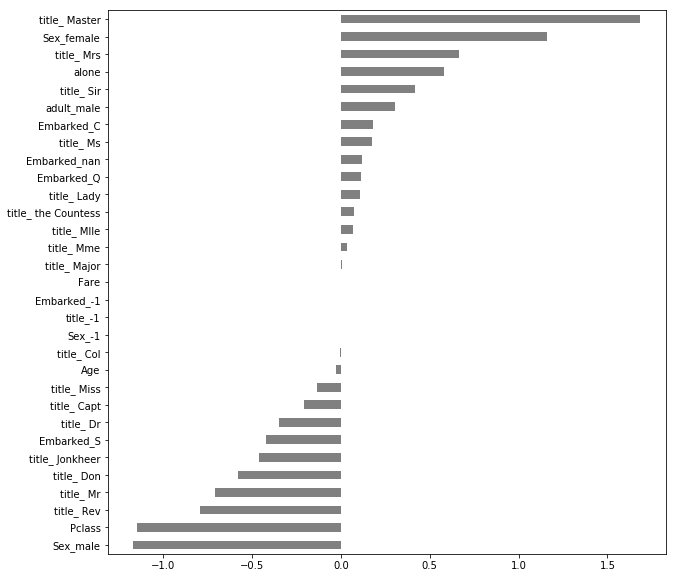

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

log_reg.fit(X_train_imputed, y_train)
coefficients = pd.Series(log_reg.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh(color='grey');

### Scaler

https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range

End-to-end example

In [37]:
from sklearn.preprocessing import MinMaxScaler

encoder = ce.OneHotEncoder(use_cat_names=True)
imputer = SimpleImputer()
scaler = MinMaxScaler()
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded  = encoder.transform(X_test)

X_train_imputed = imputer.fit_transform(X_train_encoded)
X_test_imputed  = imputer.transform(X_test_encoded)

X_train_scaled  = scaler.fit_transform(X_train_imputed)
X_test_scaled   = scaler.transform(X_test_imputed)

scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.81111111 0.82222222 0.79775281 0.86516854 0.82022472 0.78651685
 0.7752809  0.7752809  0.82022472 0.82954545]


Now all the features have a min of 0 and a max of 1

In [38]:
pd.DataFrame(X_train_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30
count,891.000000,891.000000,891.0,891.000000,891.000000,891.000000,891.000000,891.0,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.0,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.647587,0.352413,0.0,0.722783,0.188552,0.086420,0.002245,0.0,0.580247,0.140292,0.204265,0.044893,0.001122,0.006734,0.007856,0.001122,0.001122,0.002245,0.001122,0.001122,0.002245,0.002245,0.001122,0.001122,0.001122,0.0,0.654321,0.367921,0.062858,0.463524,0.602694
std,0.477990,0.477990,0.0,0.447876,0.391372,0.281141,0.047351,0.0,0.493796,0.347485,0.403390,0.207186,0.033501,0.081830,0.088337,0.033501,0.033501,0.047351,0.033501,0.033501,0.047351,0.047351,0.033501,0.033501,0.033501,0.0,0.418036,0.163383,0.096995,0.498948,0.489615
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.500000,0.271174,0.015440,0.000000,0.000000
50%,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.367921,0.028213,0.000000,1.000000
75%,1.000000,1.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.434531,0.060508,1.000000,1.000000
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


The model coefficients change with scaling

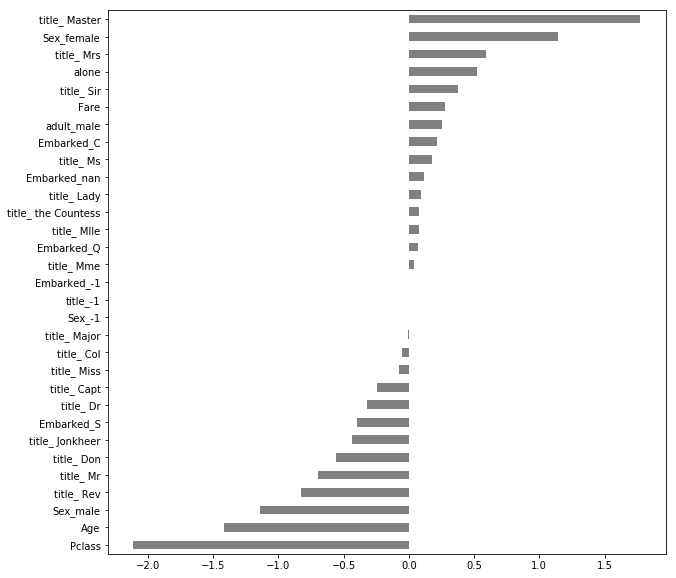

In [39]:
log_reg.fit(X_train_scaled, y_train)
coefficients = pd.Series(log_reg.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh(color='grey');

### Pipeline

https://scikit-learn.org/stable/modules/compose.html#pipeline

In [40]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    MinMaxScaler(), 
    LogisticRegression(solver='lbfgs', max_iter=1000)
)

scores = cross_val_score(pipe, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.81111111 0.82222222 0.79775281 0.86516854 0.82022472 0.78651685
 0.7752809  0.7752809  0.82022472 0.82954545]


In [41]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

submission = test[['PassengerId']].copy()
submission['Survived'] = y_pred
submission.to_csv('kaggle-submission-001.csv', index=False)

## Assignment: real-world classification

We're going to check out a larger dataset - the [FMA Free Music Archive data](https://github.com/mdeff/fma). It has a selection of CSVs with metadata and calculated audio features that you can load and try to use to classify genre of tracks. To get you started:

### Get and unzip the data

#### Google Colab

In [ ]:
!wget https://os.unil.cloud.switch.ch/fma/fma_metadata.zip
!unzip fma_metadata.zip

#### Windows
- Download the [zip file](https://os.unil.cloud.switch.ch/fma/fma_metadata.zip)
- You may need to use [7zip](https://www.7-zip.org/download.html) to unzip it


#### Mac
- Download the [zip file](https://os.unil.cloud.switch.ch/fma/fma_metadata.zip)
- You may need to use [p7zip](https://superuser.com/a/626731) to unzip it

### Look at first 4 lines of raw `tracks.csv` file

In [42]:
!head -n 4 fma_metadata/tracks.csv

,album,album,album,album,album,album,album,album,album,album,album,album,album,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,artist,set,set,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track,track
,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page,split,subset,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,1,<p></p>,6073,,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,,,"<p>A 

### Read with pandas
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [43]:
tracks = pd.read_csv('fma_metadata/tracks.csv', header=[0,1], index_col=0)

In [44]:
tracks.head()

album                                                     \
         comments         date_created        date_released engineer   
track_id                                                               
2               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
3               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
5               0  2008-11-26 01:44:45  2009-01-05 00:00:00      NaN   
10              0  2008-11-26 01:45:08  2008-02-06 00:00:00      NaN   
20              0  2008-11-26 01:45:05  2009-01-06 00:00:00      NaN   

                                                                          \
         favorites id                                information listens   
track_id                                                                   
2                4  1                                    <p></p>    6073   
3                4  1                                    <p></p>    6073   
5                4  1                                    <p></p>    6073   
10               4  6                                        NaN   47632   
20               2  4  <p> "spiritual songs" from Nicky Cook</p>    2710   

                                                            \
         producer tags                 title tracks   type   
track_id                                                     
2             NaN   []  AWOL - A Way Of Life      7  Album   
3             NaN   []  AWOL - A Way Of Life      7  Album   
5             NaN   []  AWOL - A Way Of Life      7  Album   
10            NaN   []     Constant Hitmaker      2  Album   
20            NaN   []                 Niris     13  Album   

                       artist                       \
            active_year_begin      active_year_end   
track_id                                             
2         2006-01-01 00:00:00                  NaN   
3         2006-01-01 00:00:00                  NaN   
5         2006-01-01 00:00:00                  NaN   
10                        NaN                  NaN   
20        1990-01-01 00:00:00  2011-01-01 00:00:00   

                                                             \
                                          associated_labels   
track_id                                                      
2                                                       NaN   
3                                                       NaN   
5                                                       NaN   
10        Mexican Summer, Richie Records, Woodsist, Skul...   
20                                                      NaN   

                                                                      \
                                                        bio comments   
track_id                                                               
2         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
3         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
5         <p>A Way Of Life, A Collective of Hip-Hop from...        0   
10        <p><span style="font-family:Verdana, Geneva, A...        3   
20        <p>Songs written by: Nicky Cook</p>\n<p>VOCALS...        2   

                                                                           \
                 date_created favorites id   latitude            location   
track_id                                                                    
2         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
3         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
5         2008-11-26 01:42:32         9  1  40.058324          New Jersey   
10        2008-11-26 01:42:55        74  6        NaN                 NaN   
20        2008-11-26 01:42:52        10  4  51.895927  Colchester England   

                                                                        \
          longitude                                            members   
track_id                                         

### More data prep

Get value counts of the target. (The syntax is different because the header has two levels, it's a "MultiIndex.")

The target has multiple classes, and many missing values.

In [45]:
tracks['track']['genre_top'].value_counts(normalize=True, dropna=False)

NaN                    0.534614
Rock                   0.133072
Experimental           0.099536
Electronic             0.087939
Hip-Hop                0.033329
Folk                   0.026301
Pop                    0.021882
Instrumental           0.019508
International          0.013033
Classical              0.011541
Jazz                   0.005358
Old-Time / Historic    0.005198
Spoken                 0.003969
Country                0.001820
Soul-RnB               0.001642
Blues                  0.001032
Easy Listening         0.000225
Name: genre_top, dtype: float64

We can't do supervised learning where targets are missing. (In other words, we can't do supervised learning without supervision.)

So, only keep observations where the target is not null.

In [46]:
target_not_null = tracks['track']['genre_top'].notnull()
tracks = tracks[target_not_null]

Load `features.csv`: "common features extracted from the audio with [librosa](https://librosa.github.io/librosa/)"

It has 3 levels of columns!

In [47]:
features = pd.read_csv('fma_metadata/features.csv', header=[0,1,2], index_col=0)
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
track_id                                                                 
2           1.481593  2.691455  0.866868  1.341231  1.347792  1.237658   
3           1.366848  1.054094  0.108103  0.619185  1.038253  1.292235   
5          -0.923192 -0.927232  0.666617  1.038546  0.268932  1.125141   
10          1.770694  1.604566  0.521217  1.982386  4.326824  1.300406   
20         -0.289294 -0.816410  0.043851 -0.804761 -0.990958 -0.430381   

feature                                                                 \
statistics       max                                                     
number            01        02        03        04        05        06   
track_id                                                                 
2           0.692500  0.569344  0.597041  0.625864  0.567330  0.443949   
3           0.677641  0.584248  0.581271  0.581182  0.454241  0.464841   
5           0.611014  0.651471  0.494528  0.448799  0.468624  0.454021   
10          0.461840  0.540411  0.446708  0.647553  0.591908  0.513306   
20          0.652864  0.676290  0.670288  0.598666  0.653607  0.697645   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
track_id                                                                 
2           0.487976  0.497327  0.574435  0.579241  0.620102  0.586945   
3           0.542833  0.664720  0.511329  0.530998  0.603398  0.547428   
5           0.497172  0.559755  0.671287  0.610565  0.551663  0.603413   
10          0.651501  0.516887  0.511479  0.478263  0.638766  0.638495   
20          0.664929  0.686563  0.635117  0.667393  0.689589  0.683196   

feature                                                                 \
statistics      mean                                                     
number            01        02        03        04        05        06   
track_id                                                                 
2           0.474300  0.369816  0.236119  0.228068  0.222830  0.221415   
3           0.232784  0.229469  0.225674  0.216713  0.220512  0.242744   
5           0.258420  0.303385  0.250737  0.218562  0.245743  0.236018   
10          0.229882  0.286978  0.240096  0.226792  0.192443  0.288410   
20          0.202806  0.245125  0.262997  0.187961  0.182397  0.238173   

feature                                                                 \
statistics                                                               
number            07        08        09        10        11        12   
track_id                                                                 
2           0.229238  0.248795  0.196245  0.175809  0.200713  0.319972   
3           0.369235  0.420716  0.312129  0.242748  0.264292  0.225683   
5           0.275766  0.293982  0.346324  0.289821  0.246368  0.220939   
10          0.413348  0.349137  0.268424  0.243144  0.268941  0.236763   
20          0.278600  0.292905  0.247150  0.292501  0.3

I want to [drop a level](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.MultiIndex.droplevel.html) here from the audio features dataframe, so it has the same number of levels (2) as the tracks metadata dataframe, so that I can better merge the two together.

In [48]:
features.columns = features.columns.droplevel(level=2)
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis  kurtosis  kurtosis  kurtosis  kurtosis  kurtosis   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                                                 \
statistics  kurtosis  kurtosis  kurtosis  kurtosis  kurtosis  kurtosis   
track_id                                                                 
2           1.481593  2.691455  0.866868  1.341231  1.347792  1.237658   
3           1.366848  1.054094  0.108103  0.619185  1.038253  1.292235   
5          -0.923192 -0.927232  0.666617  1.038546  0.268932  1.125141   
10          1.770694  1.604566  0.521217  1.982386  4.326824  1.300406   
20         -0.289294 -0.816410  0.043851 -0.804761 -0.990958 -0.430381   

feature                                                                 \
statistics       max       max       max       max       max       max   
track_id                                                                 
2           0.692500  0.569344  0.597041  0.625864  0.567330  0.443949   
3           0.677641  0.584248  0.581271  0.581182  0.454241  0.464841   
5           0.611014  0.651471  0.494528  0.448799  0.468624  0.454021   
10          0.461840  0.540411  0.446708  0.647553  0.591908  0.513306   
20          0.652864  0.676290  0.670288  0.598666  0.653607  0.697645   

feature                                                                 \
statistics       max       max       max       max       max       max   
track_id                                                                 
2           0.487976  0.497327  0.574435  0.579241  0.620102  0.586945   
3           0.542833  0.664720  0.511329  0.530998  0.603398  0.547428   
5           0.497172  0.559755  0.671287  0.610565  0.551663  0.603413   
10          0.651501  0.516887  0.511479  0.478263  0.638766  0.638495   
20          0.664929  0.686563  0.635117  0.667393  0.689589  0.683196   

feature                                                                 \
statistics      mean      mean      mean      mean      mean      mean   
track_id                                                                 
2           0.474300  0.369816  0.236119  0.228068  0.222830  0.221415   
3           0.232784  0.229469  0.225674  0.216713  0.220512  0.242744   
5           0.258420  0.303385  0.250737  0.218562  0.245743  0.236018   
10          0.229882  0.286978  0.240096  0.226792  0.192443  0.288410   
20          0.202806  0.245125  0.262997  0.187961  0.182397  0.238173   

feature                                                                 \
statistics      mean      mean      mean      mean      mean      mean   
track_id                                                                 
2           0.229238  0.248795  0.196245  0.175809  0.200713  0.319972   
3           0.369235  0.420716  0.312129  0.242748  0.264292  0.225683   
5           0.275766  0.293982  0.346324  0.289821  0.246368  0.220939   
10          0.413348  0.349137  0.268424  0.243144  0.268941  0.236763   
20          0.278600  0.292905  0.247150  0.292501  0.304655  0.235177   

feature                                                                 \
statistics    median    median    median    median    median    median   
track_id                                                                 
2           0.482825  0.387652  0.249082  0.238187  0.233066  0.230120   
3           0.230579  0.228059  0.209370  0.202267  0.230913  0.260300   
5           0.255472  0.293571  0.245253  0.222065  0.24

Merge the metadata with the audio features, on track id (the index for both dataframes).

In [49]:
df = pd.merge(tracks, features, left_index=True, right_index=True)

And drop a level of columns again, because dealing with MultiIndex is hard

In [50]:
df.columns = df.columns.droplevel()

This is now a pretty big dataset. Almost 500,000 rows, over 500 columns, and over 200 megabytes in RAM.

In [51]:
print(df.shape)
df.info()

(49598, 570)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49598 entries, 2 to 155319
Columns: 570 entries, comments to std
dtypes: float64(520), int64(15), object(35)
memory usage: 216.1+ MB


### Fit Logistic Regression!

In [52]:
from sklearn.model_selection import train_test_split
y = df['genre_top']
X = df.select_dtypes('number').drop(columns=['longitude', 'latitude'])
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.50, test_size=0.50, 
                                                    random_state=42, stratify=y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((24799, 533), (24799, 533), (24799,), (24799,))

In [53]:
model = LogisticRegression(solver='lbfgs', multi_class='auto')
model.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Accuracy is 37%, which sounds bad, BUT ...

In [54]:
model.score(X_test, y_test)

0.36932940844388884

... remember we have 16 classes, and the majority class (Rock) occurs 29% of the time, so the model isn't worse than random guessing for this problem

In [55]:
y.value_counts(normalize=True)

Rock                   0.285939
Experimental           0.213880
Electronic             0.188959
Hip-Hop                0.071616
Folk                   0.056514
Pop                    0.047018
Instrumental           0.041917
International          0.028005
Classical              0.024799
Jazz                   0.011513
Old-Time / Historic    0.011170
Spoken                 0.008529
Country                0.003911
Soul-RnB               0.003528
Blues                  0.002218
Easy Listening         0.000484
Name: genre_top, dtype: float64

This dataset is bigger than many you've worked with so far, and while it should fit in Colab, it can take awhile to run. That's part of the challenge!

Your tasks:
- Clean up the variable names in the dataframe
- Use logistic regression to fit a model predicting (primary/top) genre
- Inspect, iterate, and improve your model
- Answer the following questions (written, ~paragraph each):
  - What are the best predictors of genre?
  - What information isn't very useful for predicting genre?
  - What surprised you the most about your results?

*Important caveats*:
- This is going to be difficult data to work with - don't let the perfect be the enemy of the good!
- Be creative in cleaning it up - if the best way you know how to do it is download it locally and edit as a spreadsheet, that's OK!
- If the data size becomes problematic, consider sampling/subsetting, or [downcasting numeric datatypes](https://www.dataquest.io/blog/pandas-big-data/).
- You do not need perfect or complete results - just something plausible that runs, and that supports the reasoning in your written answers

If you find that fitting a model to classify *all* genres isn't very good, it's totally OK to limit to the most frequent genres, or perhaps trying to combine or cluster genres as a preprocessing step. Even then, there will be limits to how good a model can be with just this metadata - if you really want to train an effective genre classifier, you'll have to involve the other data (see stretch goals).

This is real data - there is no "one correct answer", so you can take this in a variety of directions. Just make sure to support your findings, and feel free to share them as well! This is meant to be practice for dealing with other "messy" data, a common task in data science.

## Resources and stretch goals

- Check out the other .csv files from the FMA dataset, and see if you can join them or otherwise fit interesting models with them
- [Logistic regression from scratch in numpy](https://blog.goodaudience.com/logistic-regression-from-scratch-in-numpy-5841c09e425f) - if you want to dig in a bit more to both the code and math (also takes a gradient descent approach, introducing the logistic loss function)
- Create a visualization to show predictions of your model - ideally show a confidence interval based on error!
- Check out and compare classification models from scikit-learn, such as [SVM](https://scikit-learn.org/stable/modules/svm.html#classification), [decision trees](https://scikit-learn.org/stable/modules/tree.html#classification), and [naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html). The underlying math will vary significantly, but the API (how you write the code) and interpretation will actually be fairly similar.
- Sign up for [Kaggle](https://kaggle.com), and find a competition to try logistic regression with
- (Not logistic regression related) If you enjoyed the assignment, you may want to read up on [music informatics](https://en.wikipedia.org/wiki/Music_informatics), which is how those audio features were actually calculated. The FMA includes the actual raw audio, so (while this is more of a longterm project than a stretch goal, and won't fit in Colab) if you'd like you can check those out and see what sort of deeper analysis you can do.